In [1]:
import os
import networkx as nx
import osmnx as ox
import geopandas as gpd

In [2]:
ox_crs = 4326
local_crs = 32636
example_data_path = './data'

city_geometry = gpd.read_parquet(os.path.join(example_data_path, "city_geometry.parquet")).to_crs(ox_crs)

In [3]:
from masterplan_tools.preprocessing import GraphGenerator
intermodal_graph = GraphGenerator(city_geometry=city_geometry, local_crs=local_crs).get_graph()

/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
nx.write_graphml(intermodal_graph, os.path.join(example_data_path, "intermodal.graphml"))

In [5]:
blocks = gpd.read_parquet(os.path.join(example_data_path, "blocks_cutter_result.parquet")).to_crs(local_crs)

In [6]:
from shapely import Point

nodes_gdf = gpd.GeoDataFrame(intermodal_graph.nodes(data=True), columns=['node', 'data'])
nodes_gdf['geometry'] = nodes_gdf['data'].apply(lambda d : Point(d['x'], d['y']))
nodes_gdf.set_geometry('geometry',inplace=True)
nodes_gdf.set_crs(epsg=local_crs, inplace=True)

,node,data,geometry
0,223647,"{'y': 6647609.945771661, 'x': 348845.231581590...",POINT (348845.232 6647609.946)
1,1394530252,"{'y': 6647596.453876621, 'x': 348837.362276715...",POINT (348837.362 6647596.454)
2,230327,"{'y': 6647703.931639509, 'x': 344237.408629999...",POINT (344237.409 6647703.932)
3,3661797584,"{'y': 6647689.629306875, 'x': 344246.334100829...",POINT (344246.334 6647689.629)
4,276759,"{'y': 6648707.367167073, 'x': 343874.929095455...",POINT (343874.929 6648707.367)
...,...,...,...
16399,-5216360905817630006,"{'x': 345428.07268481544, 'y': 6658792.572789221}",POINT (345428.073 6658792.573)
16400,-7230876495018779468,"{'x': 345238.50207042106, 'y': 6659147.594963456}",POINT (345238.502 6659147.595)
16401,-4672588011812921942,"{'x': 345238.28544913814, 'y': 6659148.001749729}",POINT (345238.285 6659148.002)
16402,675700352779716567,"{'x': 348455.4164721752, 'y': 6650349.555653857}",POINT (348455.416 6650349.556)


<Axes: >

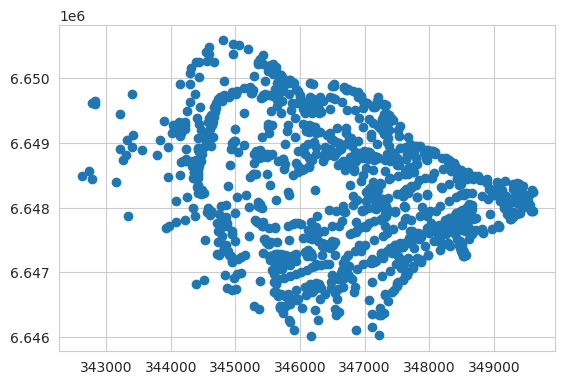

In [7]:
blocks['geometry'] = blocks['geometry'].apply(lambda x : x.representative_point())
blocks.plot()

In [8]:
blocks = blocks.loc[blocks['landuse']=='buildings']

In [9]:
import pandas as pd

sjoin = blocks.sjoin_nearest(nodes_gdf, how="left", distance_col="distance")
sjoin['weight'] = sjoin['distance']/(1000*4/60)
G = nx.MultiDiGraph(intermodal_graph)

def get_nodes(loc) -> dict[str, any]:
  nodes = []
  if isinstance(loc, pd.Series):
    nodes.append({
      'node': loc['node'],
      'weight': loc['weight']
    })
  if isinstance(loc, gpd.GeoDataFrame):
    tmp_loc = loc.copy().reset_index()
    for k in tmp_loc.index:
      nodes.append({
        'node': tmp_loc.loc[k,'node'],
        'weight': tmp_loc.loc[k,'weight']
      })
  return nodes

for i in sjoin.index:
  for j in sjoin.index:
    print(i,j)
    if i==j : 
      G.add_edge(i,j,weight=0)
    else :
      nodes_i = get_nodes(sjoin.loc[i])
      nodes_j = get_nodes(sjoin.loc[j])
      for node_i in nodes_i:
        for node_j in nodes_j:
          G.add_edge(f'block_{i}', node_i['node'], node_i['weight'])
          G.add_edge(node_i['node'], f'block_{i}', node_i['weight'])
          G.add_edge(f'block_{j}', node_j['node'], node_j['weight'])
          G.add_edge(node_j['node'], f'block_{j}', node_j['weight'])

0 0
0 4
0 6
0 11
0 24
0 59
0 64
0 66
0 69
0 71
0 82
0 84
0 87
0 90
0 93
0 106
0 107
0 112
0 114
0 117
0 118
0 119
0 120
0 124
0 125
0 126
0 127
0 128
0 129
0 132
0 140
0 141
0 184
0 192
0 193
0 194
0 196
0 198
0 207
0 208
0 210
0 215
0 229
0 236
0 239
0 241
0 242
0 248
0 257
0 262
0 277
0 295
0 308
0 312
0 313
0 314
0 318
0 319
0 320
0 342
0 343
0 347
0 349
0 351
0 355
0 357
0 359
0 373
0 375
0 391
0 394
0 405
0 406
0 407
0 408
0 409
0 410
0 411
0 412
0 426
0 427
0 430
0 439
0 442
0 448
0 470
0 500
0 513
0 517
0 520
0 523
0 531
0 534
0 535
0 543
0 546
0 557
0 565
0 568
0 575
0 581
0 583
0 590
0 591
0 594
0 606
0 608
0 609
0 610
0 612
0 615
0 617
0 619
0 620
0 623
0 625
0 629
0 635
0 642
0 648
0 657
0 663
0 665
0 666
0 668
0 672
0 675
0 676
0 677
0 682
0 692
0 695
0 696
0 699
0 715
0 716
0 724
0 726
0 730
0 738
0 747
0 748
0 752
0 765
0 774
0 779
0 787
0 791
0 797
0 798
0 809
0 812
0 815
0 843
0 844
0 852
0 857
0 860
0 867
0 870
0 875
0 885
0 887
0 888
0 889
0 891
0 907
0 911
0 912
0 91

In [26]:
blocks.explore()

In [29]:
from shapely import LineString

def path_to_linestring(graph, path):
  points = []
  for node in path:
    data = graph.nodes[node]
    points.append(Point(data['x'], data['y']))
  return LineString(points)

linestrings = []
for i in blocks.index[:20]:
  for j in blocks.index[:20]:
    if i == j : continue
    print(i,j)
    try:
      linestrings.append(path_to_linestring(G, nx.shortest_path(G, f"block_{i}", f"block_{j}")[1:-1]))
    except:
      ...
gdf = gpd.GeoDataFrame({'geometry':linestrings})

0 4
0 6
0 11
0 24
0 59
0 64
0 66
0 69
0 71
0 82
0 84
0 87
0 90
0 93
0 106
0 107
0 112
0 114
0 117
4 0
4 6
4 11
4 24
4 59
4 64
4 66
4 69
4 71
4 82
4 84
4 87
4 90
4 93
4 106
4 107
4 112
4 114
4 117
6 0
6 4
6 11
6 24
6 59
6 64
6 66
6 69
6 71
6 82
6 84
6 87
6 90
6 93
6 106
6 107
6 112
6 114
6 117
11 0
11 4
11 6
11 24
11 59
11 64
11 66
11 69
11 71
11 82
11 84
11 87
11 90
11 93
11 106
11 107
11 112
11 114
11 117
24 0
24 4
24 6
24 11
24 59
24 64
24 66
24 69
24 71
24 82
24 84
24 87
24 90
24 93
24 106
24 107
24 112
24 114
24 117
59 0
59 4
59 6
59 11
59 24
59 64
59 66
59 69
59 71
59 82
59 84
59 87
59 90
59 93
59 106
59 107
59 112
59 114
59 117
64 0
64 4
64 6
64 11
64 24
64 59
64 66
64 69
64 71
64 82
64 84
64 87
64 90
64 93
64 106
64 107
64 112
64 114
64 117
66 0
66 4
66 6
66 11
66 24
66 59
66 64
66 69
66 71
66 82
66 84
66 87
66 90
66 93
66 106
66 107
66 112
66 114
66 117
69 0
69 4
69 6
69 11
69 24
69 59
69 64
69 66
69 71
69 82
69 84
69 87
69 90
69 93
69 106
69 107
69 112
69 114
69 117
71 0
71 4


In [33]:
gdf.set_crs(epsg=local_crs).explore()